In [1]:
!pip install numpy==1.23.1
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Using cached gluonnlp-0.10.0.tar.gz (344 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661659 sha256=e8975dc64750889c08b399ceb28609acff9cb9e8e8dcb2c0710dc286fe445c71
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-3d3p31uh/kobert-tokenizer_071eeb01db774458b97d36434a0f79fa
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.g

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [3]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
device = torch.device("cuda:0")
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [4]:
import pandas as pd
# [AI Hub] 감정 분류를 위한 대화 음성 데이터셋
chatbot_data  = pd.read_csv("/content/5차년도_2차.csv", encoding='cp949')

# 7개의 감정 class → 숫자
chatbot_data.loc[(chatbot_data['상황'] == "fear"), '상황'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['상황'] == "surprise"), '상황'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['상황'] == "angry"), '상황'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['상황'] == "sadness"), '상황'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['상황'] == "neutral"), '상황'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['상황'] == "happiness"), '상황'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['상황'] == "disgust"), '상황'] = 6  #혐오 => 6

data_list = []
for q, label in zip(chatbot_data['발화문'], chatbot_data['상황'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

print(data)
print(data_list[:10])

['걱정해줘서 고마워.', '6']
[['헐! 나 이벤트에 당첨 됐어.', '5'], ['내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.', '5'], ['한 명 뽑는 거였는데, 그게 바로 내가 된 거야.', '5'], ['당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. 그래서 못 산 향수야.', '5'], ['에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.', '4'], ['난 부페 형식의 음식들도 정말 좋아해. 그 것도 좀 알려 줘.', '4'], ['응. 완전히 끝난 거야. 한 달 동안 주말에 쉬지도 못하고 일만 했거든.', '5'], ['신나는 음악 듣는 것도 좋고, 어디 여행 가고 싶고 이 것 저 것 다 해보고 싶어.', '5'], ['친구들도 내 연락 기다리고 있을 텐데 내가 까먹고 있었네?', '5'], ['그래. 일단은 친구들부터 만나서 여행 계획에 대해서 얘기 좀 해봐야 되겠어.', '5']]


In [5]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 32)

In [6]:
print(len(dataset_train), len(dataset_test))

15499 3875


In [7]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [8]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):

        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab = vocab, pad = pad, pair = pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))


    def __len__(self):
        return (len(self.labels))

In [9]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [10]:
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [11]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
# KoBERT 오픈소스 내 예제코드 : https://github.com/SKTBrain/KoBERT/blob/master/scripts/NSMC/naver_review_classifications_pytorch_kobert.ipynb
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 7,   # 감정 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [13]:
model = BERTClassifier(bertmodel,dr_rate = 0.5).to(device)

In [14]:
# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

In [16]:
train_history = []
test_history = []
loss_history = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # print(label.shape, out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    # train_history.append(train_acc / (batch_id+1))

    # .eval() : nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    # 즉, model이 Dropout이나 BatNorm2d를 사용하는 경우, train 시에는 사용하지만 evaluation을 할 때에는 사용하지 않도록 설정해주는 함수
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))


<ipython-input-16-e296f0dcd92b>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.097139358520508 train acc 0.109375
epoch 1 batch id 201 loss 1.1083012819290161 train acc 0.433613184079602
epoch 1 train acc 0.4998713991769547


<ipython-input-16-e296f0dcd92b>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 1 test acc 0.8435450819672131


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.528444766998291 train acc 0.859375
epoch 2 batch id 201 loss 0.4778786897659302 train acc 0.8792754975124378
epoch 2 train acc 0.8844521604938271


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 2 test acc 0.9004537470725995


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.12690085172653198 train acc 0.96875
epoch 3 batch id 201 loss 0.23441456258296967 train acc 0.9203202736318408
epoch 3 train acc 0.9232253086419753


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 3 test acc 0.9054449648711943


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.07728451490402222 train acc 0.96875
epoch 4 batch id 201 loss 0.17277413606643677 train acc 0.9398320895522388
epoch 4 train acc 0.9409079218106996


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 4 test acc 0.9072819086651054


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.031610310077667236 train acc 1.0
epoch 5 batch id 201 loss 0.27348315715789795 train acc 0.9574782338308457
epoch 5 train acc 0.9581404320987654


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 5 test acc 0.9071940866510538


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.01494312658905983 train acc 1.0
epoch 6 batch id 201 loss 0.16915364563465118 train acc 0.9611318407960199
epoch 6 train acc 0.9614840534979424


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 6 test acc 0.9151785714285714


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.024899322539567947 train acc 1.0
epoch 7 batch id 201 loss 0.08804873377084732 train acc 0.9710820895522388
epoch 7 train acc 0.9709362139917695


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 7 test acc 0.9159470140515222


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.00950488168746233 train acc 1.0
epoch 8 batch id 201 loss 0.14262133836746216 train acc 0.9741138059701493
epoch 8 train acc 0.9739583333333334


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 8 test acc 0.9161592505854801


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.06415538489818573 train acc 0.984375
epoch 9 batch id 201 loss 0.038092710077762604 train acc 0.9797108208955224
epoch 9 train acc 0.9797453703703703


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 9 test acc 0.9173960772833724


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.012238260358572006 train acc 1.0
epoch 10 batch id 201 loss 0.014694795943796635 train acc 0.9825870646766169
epoch 10 train acc 0.982445987654321


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 10 test acc 0.9148346018735363


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.00553717790171504 train acc 1.0
epoch 11 batch id 201 loss 0.006420921999961138 train acc 0.9860074626865671
epoch 11 train acc 0.98559670781893


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 11 test acc 0.9184206674473068


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.00406693946570158 train acc 1.0
epoch 12 batch id 201 loss 0.09004845470190048 train acc 0.9879508706467661
epoch 12 train acc 0.9879758230452675


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 12 test acc 0.9158591920374707


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.0033050859346985817 train acc 1.0
epoch 13 batch id 201 loss 0.008443323895335197 train acc 0.9895833333333334
epoch 13 train acc 0.9895833333333334


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 13 test acc 0.9207259953161592


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.0008344314992427826 train acc 1.0
epoch 14 batch id 201 loss 0.004127556923776865 train acc 0.9912935323383084
epoch 14 train acc 0.9911908436213992


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 14 test acc 0.9199575526932083


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.005454826168715954 train acc 1.0
epoch 15 batch id 201 loss 0.0017999074188992381 train acc 0.9916822139303483
epoch 15 train acc 0.9920910493827161


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 15 test acc 0.9212382903981264


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.002036172430962324 train acc 1.0
epoch 16 batch id 201 loss 0.004233746323734522 train acc 0.9930814676616916
epoch 16 train acc 0.9931198559670782


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 16 test acc 0.9245682084309133


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.0007439355831593275 train acc 1.0
epoch 17 batch id 201 loss 0.014219696633517742 train acc 0.9935478855721394
epoch 17 train acc 0.993505658436214


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 17 test acc 0.9232874707259953


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.0006714790943078697 train acc 1.0
epoch 18 batch id 201 loss 0.00593792786821723 train acc 0.9950248756218906
epoch 18 train acc 0.9950488683127572


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 18 test acc 0.9245682084309133


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.001087085111066699 train acc 1.0
epoch 19 batch id 201 loss 0.0023173692170530558 train acc 0.9945584577114428
epoch 19 train acc 0.9945344650205762


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 19 test acc 0.9248243559718969


  0%|          | 0/243 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.0012762751430273056 train acc 1.0
epoch 20 batch id 201 loss 0.004675982519984245 train acc 0.9947139303482587
epoch 20 train acc 0.9948559670781894


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 20 test acc 0.9245682084309133


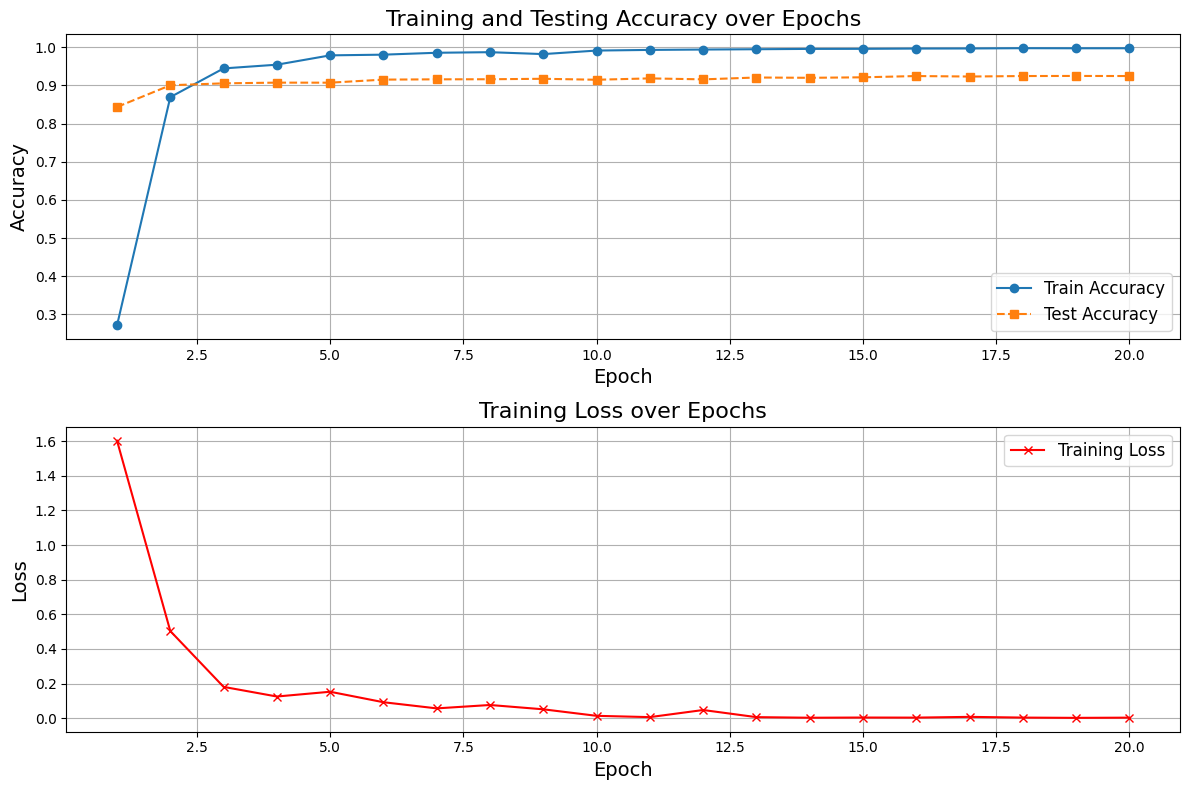

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 각 epoch에 해당하는 정확도 및 loss 값을 추출
train_epoch_acc = np.array_split(train_history, num_epochs)
train_epoch_acc = [np.mean(epoch) for epoch in train_epoch_acc]

test_epoch_acc = np.array_split(test_history, num_epochs)
test_epoch_acc = [np.mean(epoch) for epoch in test_epoch_acc]

epoch_loss = np.array_split(loss_history, num_epochs)
epoch_loss = [np.mean(epoch) for epoch in epoch_loss]

# 그래프 그리기
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Accuracy 그래프
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째 그래프
plt.plot(epochs, train_epoch_acc, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, test_epoch_acc, label='Test Accuracy', marker='s', linestyle='--')
plt.title('Training and Testing Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Loss 그래프
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째 그래프
plt.plot(epochs, epoch_loss, label='Training Loss', marker='x', linestyle='-', color='red')
plt.title('Training Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
# 모델 학습이 끝난 후 저장
MODEL_PATH = "kobert_emotion_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to kobert_emotion_model.pth


In [19]:
# predict : 학습 모델을 활용하여 다중 분류된 클래스를 출력해주는 함수
# 코드 출처 : https://hoit1302.tistory.com/159

def predict(predict_sentence): # input = 감정분류하고자 하는 sentence

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval = []
        for i in out: # out = model(token_ids, valid_length, segment_ids)
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")


In [ ]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")


>> 입력하신 내용에서 놀람이 느껴집니다.


